## CREATING QA BOT WITH PYTHON

In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

### Load Data

In [4]:
#Loading training data
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [5]:
#Loading test data
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [12]:
len(train_data), len(test_data)

(10000, 1000)

In [13]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

#### Train data contains 10, 000 tuples. Each tuple holds a list comprehension of the story, question, and  a "yes"/"no" answer.

In [15]:
# Story
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [16]:
# Question
" ".join(train_data[0][1])

'Is Sandra in the hallway ?'

In [19]:
# Answer
train_data[0][2]

'no'

### Data Preparation

In [26]:
def vocab_creator(data):
    '''
    Creating vocabulary of words present in our data
    '''
    vocab = set()
    for story, question, answer in data:
        vocab = vocab.union(set(story))
        vocab = vocab.union(set(question))
    vocab.add('yes')
    vocab.add('no')
    
    tokenizer = Tokenizer(filters = [])
    tokenizer.fit_on_texts(vocab)
    
    max_story_len = max([len(datum[0]) for datum in data]) #maximum story length
    max_question_len = max([len(datum[1]) for datum in data]) #maximum question length
    
    return tokenizer, max_story_len, max_question_len, vocab

In [23]:
def vectorize_stories(data, word_index = tokenizer.word_index, 
                      max_story_len = max_story_len, 
                      max_question_len = max_question_len):
    '''
    Vectorizes story, question, and answer with padded sequences
    X = Stories
    X_Q = Questions
    Y  = Answers
    '''
    X  = []
    X_Q = []
    Y = []
    
    for stories ,questions, answers in data:
        '''
        For each story
        [23,14,43,...]
        '''
        x = [word_index[word.lower()] for word in stories]
        x_q = [word_index[word.lower()] for word in questions]
        
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answers]] = 1
        
        X.append(x)
        X_Q.append(x_q)
        Y.append(y)
    return (pad_sequences(X, maxlen = max_story_len), pad_sequences(X_Q, maxlen = max_question_len), np.array(Y))

In [24]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [25]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [29]:
def data_preprocessing(train_data, test_data):
    all_data = train_data + test_data # Combine train data and test data
    
    tokenizer, max_story_len, max_question_len, vocab = vocab_creator(all_data)    
    vocab_size = len(vocab) + 1 #size of our vocabulary
    
    input_sequence = Input((max_story_len,)) #placeholder for shape = (max_story_len, batch_size)
    question = Input((max_question_len,))
    
    return vocab_size, input_sequence, question

### DATA MODELING

In [27]:
def model(vocab_size = vocab_size, max_question_len = max_question_len, input_sequence = input_sequence, question = question):
    '''
    Input Encoder M
    Gets embedded to a seq of vecotrs
    '''
    input_encoder_m = Sequential()
    input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim = 64))
    input_encoder_m.add(Dropout(0.3))

    '''
    Input Encoder C
    Gets embedded to a seq of vecotrs
    '''
    input_encoder_c = Sequential()
    input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim = max_question_len))
    input_encoder_c.add(Dropout(.3))
    
    '''
    Question Encoder
    '''
    question_encoder = Sequential()
    question_encoder.add(Embedding(input_dim=vocab_size, output_dim = 64, input_length = max_question_len))
    question_encoder.add(Dropout(.3))
    
    '''
    ENCODED RESULT <-- ENCODER(INPUT)
    '''
    input_encoded_m = input_encoder_m(input_sequence)
    input_encoded_c = input_encoder_c(input_sequence)
    question_encoded =  question_encoder(question)

    '''
    Use dot product to compute the match between the first input vector
    seq and the query
    '''
    match = dot([input_encoded_m, question_encoded], axes =(2,2))
    match = Activation('softmax')(match)
    
    '''
    Add above match matrix to second input vector seq
    '''
    response = add([match, input_encoded_c])
    response = Permute((2,1))(response) # convert it to have a output of samples dim by query_max_len by story_max_len
    
    '''
    Now we can concat the match matrix with the question vector seq
    '''
    answer = concatenate([response, question_encoded])
    answer = LSTM(32)(answer)
    answer = Dropout(0.5)(answer)
    answer = Dense(vocab_size)(answer) # (sample, vocab_size)
    answer = Activation('softmax')(answer)
    model = Model([input_sequence, question], answer)
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
vocab_size, input_sequence, question = data_preprocessing(train_data, test_data)
model = model()

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

### TRAINING

In [32]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size = 32, epochs = 50, validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 4s 424us/step - loss: 0.8615 - acc: 0.4930 - val_loss: 0.6939 - val_acc: 0.5030
Epoch 2/50
10000/10000 [==============================] - 3s 337us/step - loss: 0.7007 - acc: 0.5039 - val_loss: 0.6941 - val_acc: 0.5030
Epoch 3/50
10000/10000 [==============================] - 3s 340us/step - loss: 0.6957 - acc: 0.4978 - val_loss: 0.6935 - val_acc: 0.5030
Epoch 4/50
10000/10000 [==============================] - 3s 338us/step - loss: 0.6950 - acc: 0.4997 - val_loss: 0.6933 - val_acc: 0.5030
Epoch 5/50
10000/10000 [==============================] - 3s 339us/step - loss: 0.6950 - acc: 0.4946 - val_loss: 0.6943 - val_acc: 0.5030
Epoch 6/50
10000/10000 [==============================] - 4s 406us/step - loss: 0.6942 - acc: 0.5011 - val_loss: 0.6963 - val_acc: 0.4970
Epoch 7/50
10000/10000 [==============================] - 4s 425us/step - loss: 0.6949 - acc: 0.4955 - val_loss: 0.6937 - v

### Evaluating Model
#### Plotting Training History

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


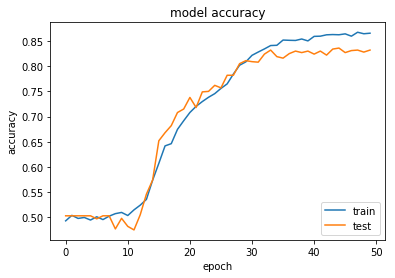

In [34]:
print(history.history.keys())

#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

In [35]:
model.save('qachatbot.h5')